In [1]:
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import torchvision
from IPython.display import clear_output

Download and preprocess the dataset with the images of handwritted digits.

In [3]:
transform = torchvision.transforms.Compose(
    [
        # The images in the dataset are in PIL format: (H x W x C) in the range [0, 255]
        # This transformes them to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
        torchvision.transforms.ToTensor(),
        # Applies transformation (x - 0.5)/0.5
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

In [4]:
mnist = torchvision.datasets.MNIST("/mnt/nkazeev/.mnist", download=True, transform=transform)

Create a helper that, would split the data into batches to be used during the training

In [5]:
BATCH_SIZE = 256
# We ask for a loader that outputs data in bathes with size BATCH_SIZE,
# shuffles the dataset after each epoch, and prepares the data to be uploaded to a GPU
# https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-pinning
images_loader = torch.utils.data.DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [6]:
# Let's see, what we've got
batch_images, batch_labels = next(iter(images_loader))

In [7]:
# A batch of digit classes
batch_labels

tensor([4, 5, 2, 7, 8, 9, 7, 7, 6, 0, 5, 0, 7, 5, 9, 2, 4, 6, 5, 2, 6, 5, 1, 6,
        0, 2, 3, 1, 0, 1, 7, 1, 6, 0, 5, 4, 9, 1, 5, 3, 1, 2, 7, 2, 7, 3, 3, 7,
        2, 2, 5, 7, 6, 1, 7, 6, 1, 1, 3, 1, 0, 6, 3, 6, 0, 4, 7, 4, 3, 9, 1, 6,
        7, 9, 3, 8, 2, 5, 7, 0, 7, 1, 6, 4, 5, 9, 5, 6, 9, 4, 8, 0, 4, 9, 0, 3,
        4, 9, 6, 2, 7, 9, 5, 2, 3, 8, 4, 9, 9, 2, 8, 6, 3, 8, 3, 0, 8, 4, 1, 0,
        1, 0, 4, 4, 9, 4, 7, 7, 4, 1, 3, 9, 1, 4, 1, 0, 2, 5, 3, 1, 0, 3, 2, 5,
        8, 8, 2, 4, 2, 0, 8, 9, 8, 9, 8, 4, 4, 9, 8, 5, 5, 7, 9, 7, 8, 4, 2, 1,
        1, 6, 3, 9, 6, 0, 3, 3, 6, 7, 8, 6, 1, 9, 8, 3, 0, 7, 7, 2, 3, 2, 2, 2,
        4, 7, 2, 2, 0, 4, 7, 9, 6, 9, 9, 3, 8, 6, 1, 9, 0, 8, 1, 9, 7, 2, 7, 6,
        6, 3, 8, 8, 1, 3, 8, 9, 2, 1, 6, 6, 5, 2, 7, 4, 1, 1, 8, 4, 3, 9, 6, 3,
        8, 2, 0, 0, 7, 3, 6, 2, 7, 1, 8, 0, 4, 9, 6, 3])

In [8]:
# And a batch images in format [batch_size, channels, width, height]
batch_images.shape

torch.Size([256, 1, 28, 28])

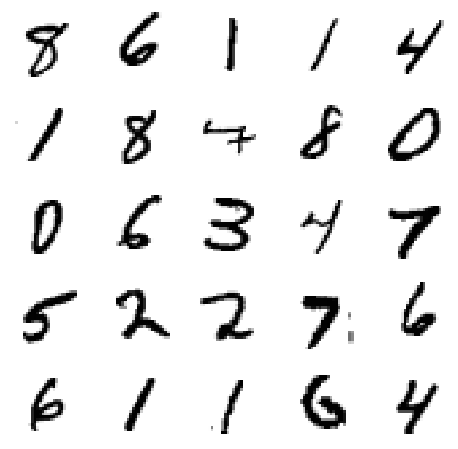

In [9]:
def plot_images(images: np.ndarray,
                nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
  """
  Plots a subset of images. A matplotlib-based alternative to torchvision.utils.make_grid
  
  Args:
    images[n_images, 1, width, height]: a dataset with greyscale images to plot
    nrows: number of images in a plotted row
    ncols: numer of images in a plotted colunm
    shuffle: if True draw a random subset of images, if False -- the first ones
    figure: if not None, it's used for plotting, if None, a new one is created
  
  Returns:
    a figure containing the plotted images
  """
  if shuffle:
    images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
  else:
    images_to_plot = images[:nrows * ncols]
  h, w = images_to_plot.shape[2:]
  if figure is None:
    figure = plt.figure(figsize=(8,8))
  
  axes = figure.subplots(nrows=nrows, ncols=ncols)
  for row_idx, ax_row in enumerate(axes):
    for col_idx, ax in enumerate(ax_row):
      ax.imshow(images_to_plot[row_idx + ncols*col_idx, 0],
                cmap="gray_r",
                interpolation="none")
      ax.set_axis_off()
  return figure

plot_images(batch_images);

In [10]:
import torch
from torch import nn
from torch.nn.functional import logsigmoid
import mnist_gan

In [11]:
GENERATOR_FILE = 'generator.pt'
DISCRIMINATOR_FILE = 'discriminator.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
generator = mnist_gan.Generator(code_size=100).to(device)

In [13]:
noise_distribution = torch.distributions.Normal(0, 1)
def sample_fake(batch_size):
  noise = noise_distribution.sample((batch_size, generator.code_size)).to(device)
  return generator(noise)

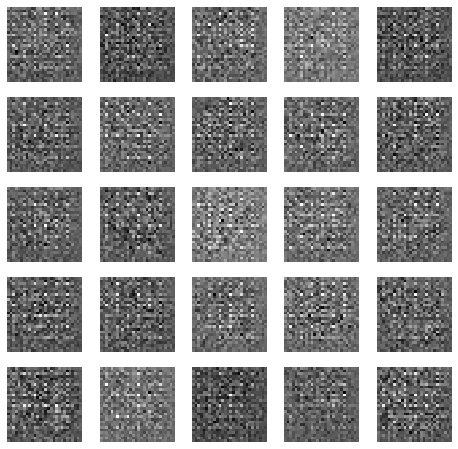

In [14]:
generator.eval()
test_size = 25
imgs = sample_fake(test_size).cpu().detach().numpy()
assert imgs.shape == (test_size, 1, 28, 28)
plot_images(imgs); # Displays proper noise.

In [15]:
discriminator = mnist_gan.Discriminator().to(device)

In [16]:
def generator_loss(fake):
    return -logsigmoid(discriminator(fake)).mean()
  
def discriminator_loss(real, fake):
    return -logsigmoid(discriminator(real)).mean() - \
          logsigmoid(-discriminator(fake)).mean()

In [17]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=1e-3)
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=1e-3)

disc_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.99)
gen_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size=10, gamma=0.99)

In [18]:
from torch.utils.tensorboard import SummaryWriter
TENSORBOARD_LOGDIR = "./logs"
MODEL_NAME = "MNIST_v7"
summary_writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOGDIR, MODEL_NAME))

In [19]:
VALIDATION_INTERVAL = 50
SAVE_INTERVAL = 500
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 1

In [20]:
# Last touch. We wrap up the DataLoader to produce an infinite stream of images
def image_sampler():
    while True:
        for images, targets in images_loader:
            yield images

sampler = image_sampler()
def sample_images():
    return next(sampler)

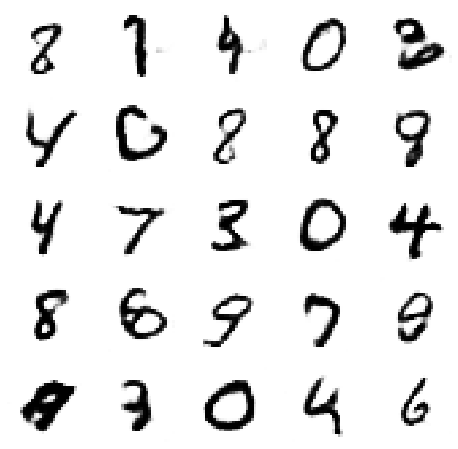

In [ ]:
for i in range(1000000):
  generator.train(mode=False)
  discriminator.train(mode=True)
  # Can do several discriminator updates per step
  for j in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
    # Sampling reals and fakes
    real = sample_images().to(device) # BATCH_SIZE is alrady in definition
    fake = sample_fake(BATCH_SIZE)

    # Calculating the loss
    discriminator_loss_this_iter = discriminator_loss(real, fake)

    # Doing our regular optimization step for the discriminator
    optimizer_discriminator.zero_grad()
    discriminator_loss_this_iter.backward()
    optimizer_discriminator.step()

  # Pass the discriminator loss to Tensorboard for plotting 
  summary_writer.add_scalar("discriminator loss", discriminator_loss_this_iter,
                             global_step=i)

  # Now it's generator's time to learn:
  generator.train(mode=True)
  discriminator.train(mode=False)
  generator_loss_this_iter = generator_loss(sample_fake(BATCH_SIZE))
  summary_writer.add_scalar("generator loss", generator_loss_this_iter,
                            global_step=i)
  optimizer_generator.zero_grad()
  generator_loss_this_iter.backward()
  optimizer_generator.step()

  gen_scheduler.step()
  disc_scheduler.step()
    
  if i % SAVE_INTERVAL == 0:
    torch.save(generator.state_dict(), GENERATOR_FILE)
    torch.save(discriminator.state_dict(), DISCRIMINATOR_FILE)
    
  if i % VALIDATION_INTERVAL == 0:
    clear_output(wait=True)
    generator.eval()
    imgs = sample_fake(25).cpu().detach().numpy()
    plot_images(imgs)
    plt.show();